In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanicdataset/data.csv
/kaggle/input/titanticdataset/test.csv
/kaggle/input/titanticdataset/train.csv
/kaggle/input/titanic/train_and_test2.csv


In [2]:
!conda install -c ankurankan pgmpy --yes
from pgmpy.factors.discrete import TabularCPD


Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pgmpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py36_0         2.8 MB
    pgmpy-0.1.10               |           py36_0       386.5 MB  ankurankan
    ------------------------------------------------------------
                                           Total:       389.3 MB

The following NEW packages will be INSTALLED:

  pgmpy              ankurankan/linux-64::pgmpy-0.1.10-py36_0

The following packages will be UPDATED:

  conda                                        4.8.2-py36_0 --> 4.8.3-py36_0



pgmpy-0.1.10         | 386.5 MB  | ##################################### | 100% 
conda-4.8.3          | 2.8 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing tr

In [14]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor 
from pgmpy.inference import BeliefPropagation
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator,BayesianEstimator,ConstraintBasedEstimator,HillClimbSearch, BicScore,K2Score,ExhaustiveSearch


import numpy as np
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanicdataset/data.csv
/kaggle/input/titanticdataset/test.csv
/kaggle/input/titanticdataset/train.csv
/kaggle/input/titanic/train_and_test2.csv


In [4]:
train=pd.read_csv('../input/titanticdataset/train.csv')
test=pd.read_csv('../input/titanticdataset/test.csv')

In [5]:
train['source']='train'
test['source']='test'
data=pd.concat([train,test],axis=0)
data.isnull().sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
source            0
dtype: int64

In [6]:
data.describe()

#data.to_csv('data.csv')

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [ ]:
data.head()

In [7]:
#Binning the variables
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['source']]
# Categorical values need to be transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'], 10, labels=False)

In [8]:

train=data[data['source']=='train']
test=data[data['source']=='test']

train.dropna(axis=0, inplace=True)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


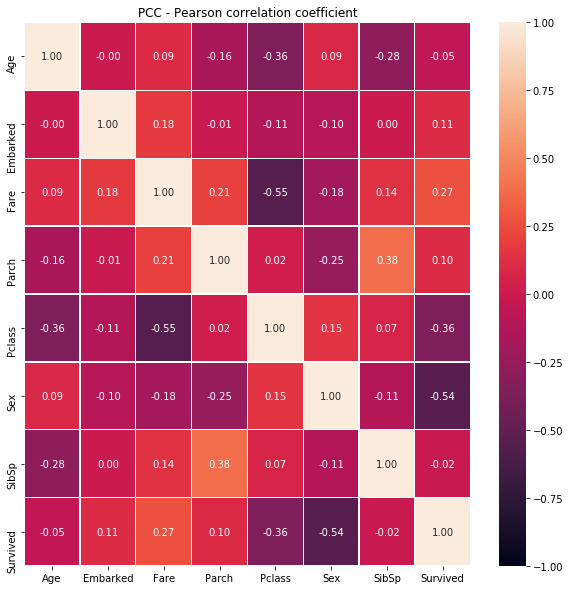

In [9]:
#Correlation martix
columns = train[features + [target]].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)

# Apply Pearson correlation on each pair of features.
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = pearsonr(train.loc[:, columns[col_a]], train.loc[:,  columns[col_b]])[0]
        
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=.2)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

In [10]:
train=train.drop('source',axis=1)
test=test.drop('source',axis=1)
#!pip install bnlearn
#import bnlearn
#model  = bnlearn.structure_learning.fit(train, methodtype='ex', scoretype='bic')
#G = bnlearn.plot(model)


In [12]:
#!pip install bnlearn
import bnlearn

In [ ]:
#model  = bnlearn.structure_learning.fit(train[:1], methodtype='ex', scoretype='bic')
#G = bnlearn.plot(model)

In [ ]:
#Building the structure and finding imp features
#!pip install pomegranate


#ExhaustiveSearch
est_e = ExhaustiveSearch(train, scoring_method=BicScore(data))
model = est_e.estimate()
model.edges()

In [ ]:
#HIllClimbSearch
est_h = HillClimbSearch(train, scoring_method=BicScore(data))
model = est_h.estimate()
model.edges()

In [ ]:
nx.draw_networkx(model)
plt.show()

In [ ]:
model.nodes()

In [ ]:
#Define a Bayesian Network
BN_Model = BayesianModel([('Survived', 'Pclass'), 
                        ('Survived', 'Sex'), 
                        ('Sex', 'Pclass'),
                        ('Pclass','Embarked')]) 

In [ ]:

nx.draw_networkx(BN_Model,with_labels=True) 
plt.show() 

In [ ]:
#Fit the Model
BN_Model.fit(train, estimator=BayesianEstimator) 

In [ ]:
BN_Model.get_cpds()

In [ ]:

model_inference=VariableElimination(BN_Model)


In [ ]:
test.isnull().sum()


In [ ]:
x=BN_Model.predict(test[['Embarked','Pclass','Sex']])

In [ ]:
x['Survived'].value_counts()

In [ ]:
x.to_csv(r'Survived.csv')
from IPython.display import FileLink
FileLink(r'Survived.csv')

In [ ]:
#Answer=0.75988

In [ ]:
print(model_inference.map_query(variables=['income'], evidence ={ 'age': 'below_28', 'education': 'Bachelors','occupation':'Prof-specialty','workclass':'State-gov'})) 

In [15]:
#Hill climbing search with k2score

est_h = HillClimbSearch(train, scoring_method=K2Score(data))
model = est_h.estimate()
model.edges()

OutEdgeView([('Embarked', 'Fare'), ('Fare', 'Pclass'), ('Parch', 'Age'), ('Parch', 'Fare'), ('Parch', 'SibSp'), ('Parch', 'Sex'), ('Pclass', 'Survived'), ('Pclass', 'Age'), ('Sex', 'Survived'), ('SibSp', 'Fare'), ('SibSp', 'Sex')])

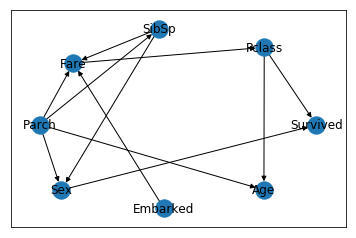

In [16]:
nx.draw_networkx(model)
plt.show()

In [ ]:
model.nodes()

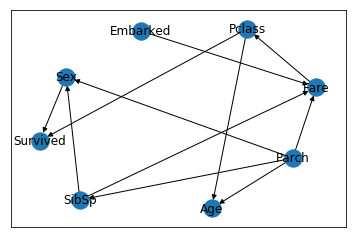

In [17]:
#Define a Bayesian Network
BN_Model = BayesianModel([('Embarked', 'Fare'), ('Fare', 'Pclass'), ('Parch', 'Age'), ('Parch', 'Fare'), ('Parch', 'SibSp'), ('Parch', 'Sex'), ('Pclass', 'Survived'), ('Pclass', 'Age'), ('Sex', 'Survived'), ('SibSp', 'Fare'), ('SibSp', 'Sex')]) 
nx.draw_networkx(BN_Model,with_labels=True) 
plt.show() 

In [22]:
#Fit the Model
BN_Model.fit(train, estimator=MaximumLikelihoodEstimator) 

In [23]:
BN_Model.get_cpds()
model_inference=VariableElimination(BN_Model)


In [38]:

test['Fare']=test['Fare'].replace(np.nan,test['Fare'].mean())
test.isnull().sum()

Age          86
Embarked      0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
dtype: int64

In [102]:
for var in test.columns:
    print(var)
    print(test[var].value_counts())

data=test[['Embarked','Pclass','Sex']]

Age
2.0    41
3.0    40
8.0    35
5.0    32
4.0    32
1.0    31
9.0    31
7.0    30
0.0    30
6.0    30
Name: Age, dtype: int64
Embarked
1.0    270
2.0    102
3.0     46
Name: Embarked, dtype: int64
Fare
7.7500     21
26.0000    19
8.0500     17
13.0000    17
7.8958     11
           ..
9.3250      1
14.4583     1
15.0333     1
25.4667     1
21.0750     1
Name: Fare, Length: 170, dtype: int64
Parch
0    324
1     52
2     33
3      3
9      2
4      2
6      1
5      1
Name: Parch, dtype: int64
Pclass
3    218
1    107
2     93
Name: Pclass, dtype: int64
Sex
1    266
0    152
Name: Sex, dtype: int64
SibSp
0    283
1    110
2     14
4      4
3      4
8      2
5      1
Name: SibSp, dtype: int64
Survived
Series([], Name: Survived, dtype: int64)


In [105]:
x=BN_Model.predict(test)






















  0%|          | 0/267 [00:00<?, ?it/s]

















  3%|▎         | 8/267 [00:03<01:38,  2.62it/s]

KeyError: 7.8292

In [25]:
x['Survived'].value_counts()

0.0    338
1.0     80
Name: Survived, dtype: int64

In [26]:
x.to_csv(r'Survived1.csv')
from IPython.display import FileLink
FileLink(r'Survived1.csv')

/kaggle/working/Survived1.csv